In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, ParameterGrid
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_squared_error
import warnings
import time
warnings.filterwarnings("ignore")

In [99]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

East North Central
58.94473195075989
East North Central
MASE:  1.1379874778863317
RMSE:  10836.310707539651
MAE:  9022.504645748988
Best Parameters:  {'d': 0, 'p': 5, 'q': 3}
East South Central
61.81394815444946
East South Central
MASE:  1.2107095899716813
RMSE:  5787.03053171809
MAE:  4007.6755667440457
Best Parameters:  {'d': 0, 'p': 5, 'q': 4}
Mid-Atlantic
59.250977993011475
Mid-Atlantic
MASE:  2.4474880551853686
RMSE:  6597.6713756763265
MAE:  5195.823604998455
Best Parameters:  {'d': 1, 'p': 4, 'q': 5}
Mountain
62.65172791481018
Mountain
MASE:  1.5012610273643439
RMSE:  7516.324834683296
MAE:  4746.119851509026
Best Parameters:  {'d': 1, 'p': 3, 'q': 4}
New England
61.078356981277466
New England
MASE:  1.116958117907015
RMSE:  4135.2255391340295
MAE:  2788.1734104946213
Best Parameters:  {'d': 2, 'p': 5, 'q': 5}
Pacific
58.142879009246826
Pacific
MASE:  2.1691114736774106
RMSE:  19976.9946567052
MAE:  14529.803761715111
Best Parameters:  {'d': 0, 'p': 4, 'q': 5}
South Atlantic
58.

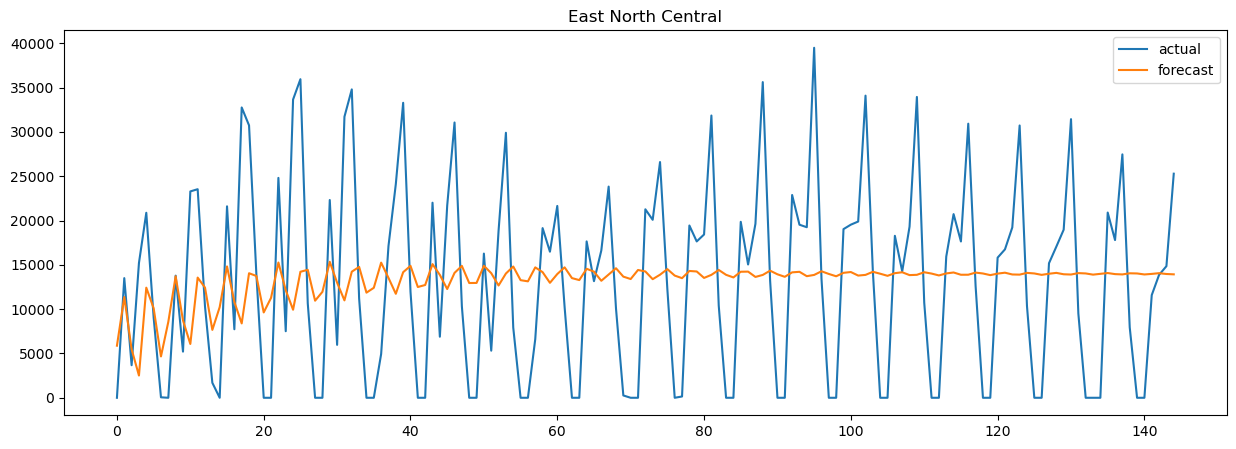

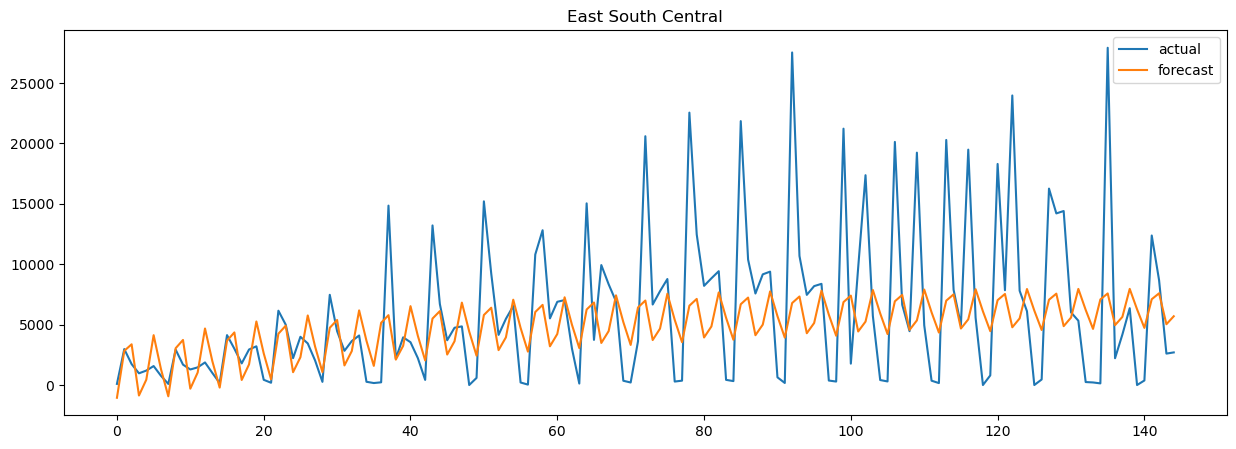

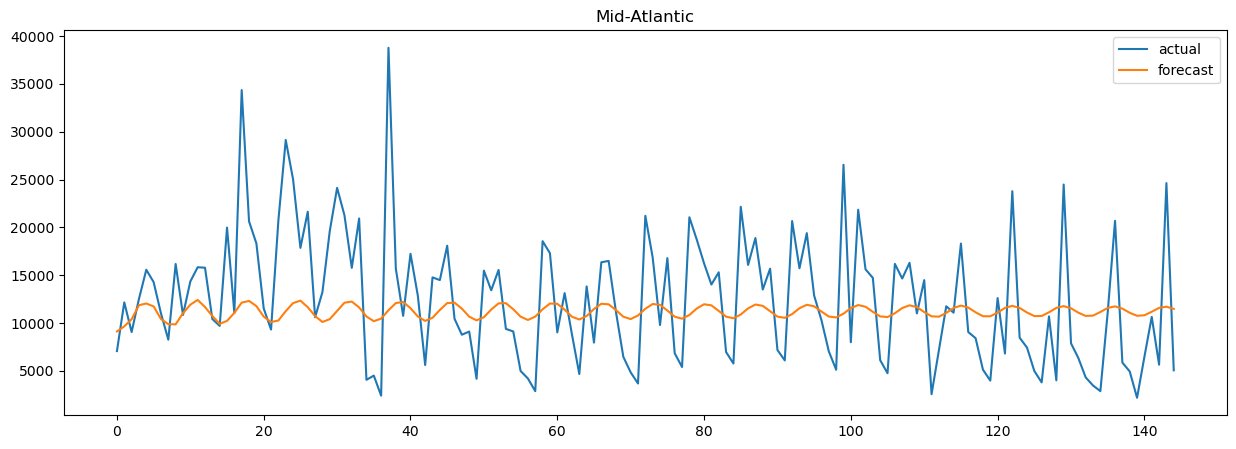

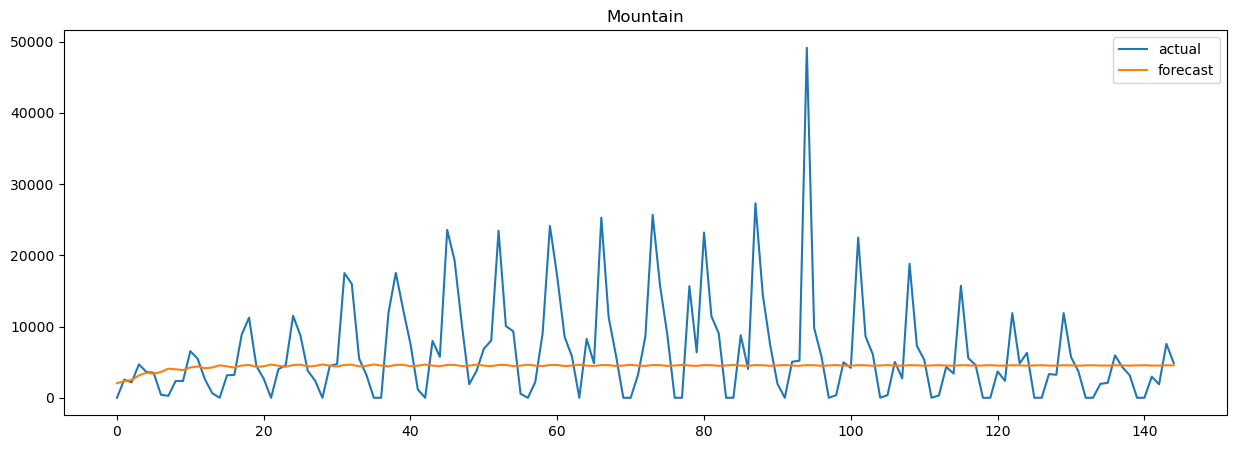

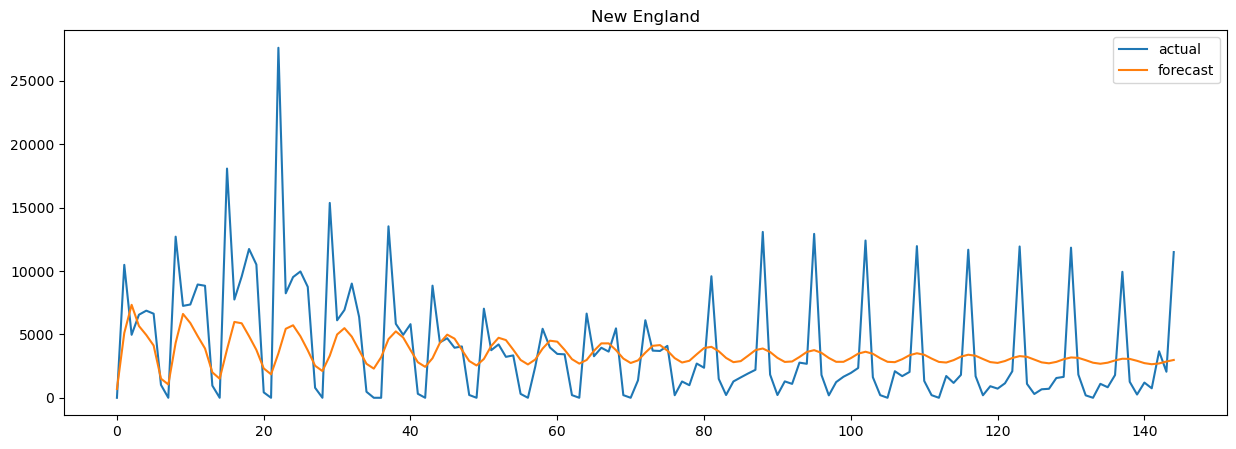

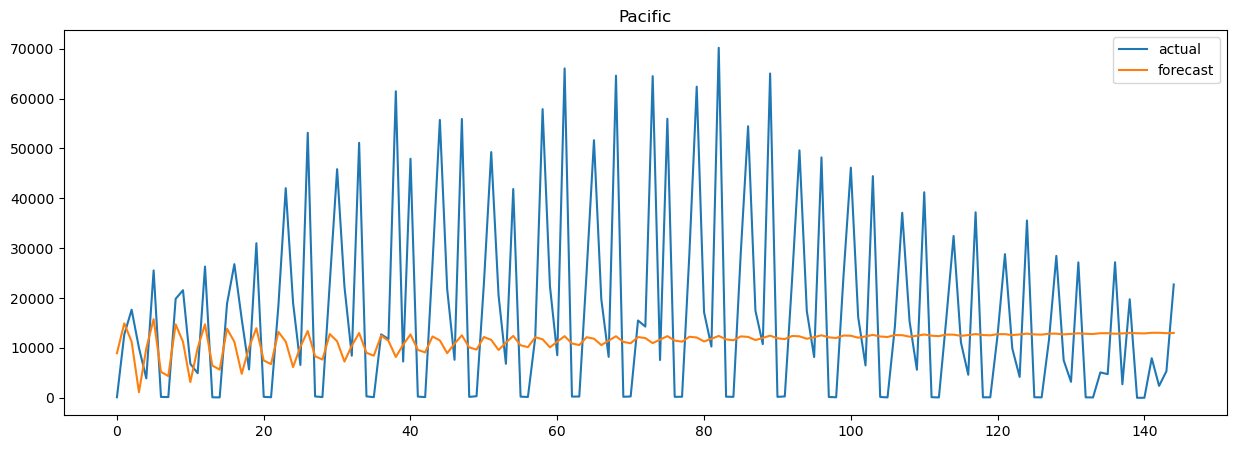

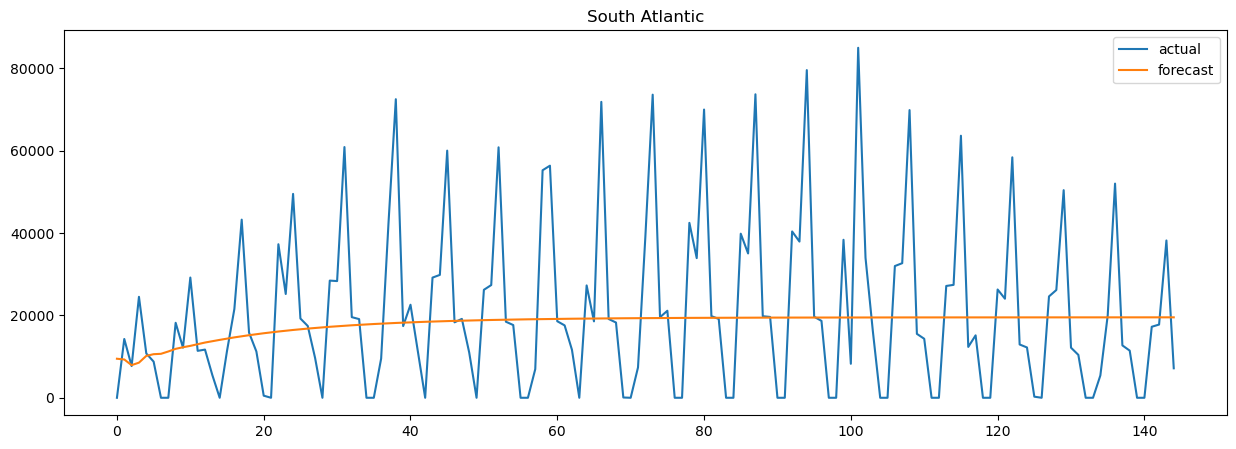

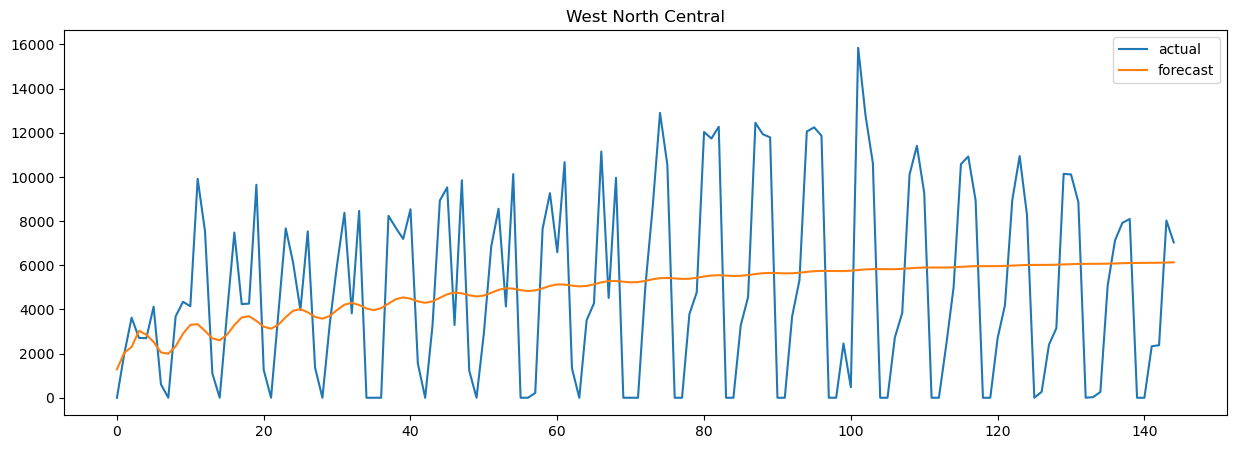

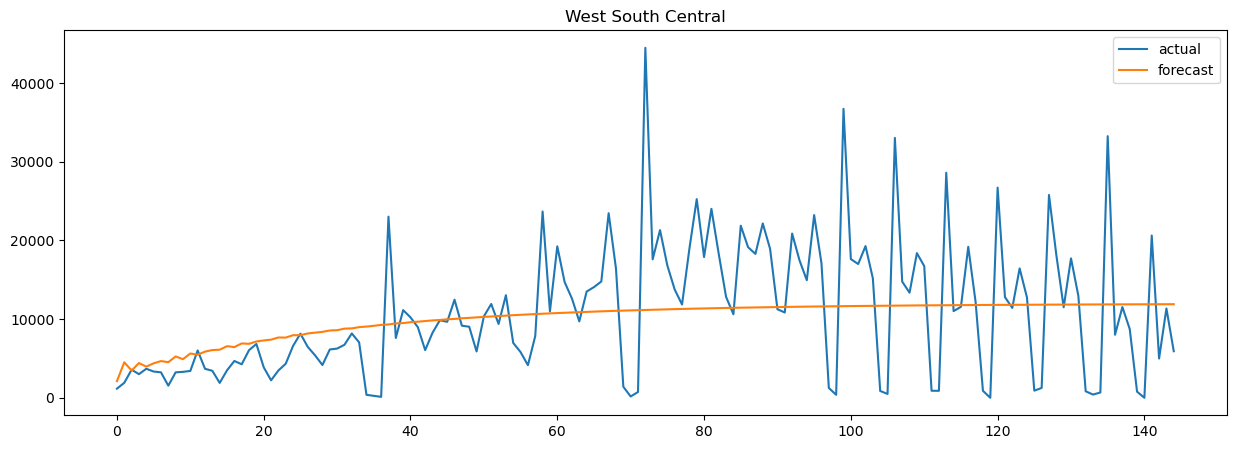

In [118]:
params_grid = {'p': [0,1,2,3,4,5],
               'd': [0,1,2,3,4,5],
               'q': [0,1,2,3,4,5]}
grid = ParameterGrid(params_grid)
best_params = []
best_params2 = []
best_smape = []
best_mase = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    start = time.time()
    print(data1.region.unique()[0])
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    params = []
    smapes = []
    mases = []
    for param in grid:
        params.append(param)
        model = ARIMA(train.y, order = (param['p'], param['d'], param['q']))
        model.initialize_approximate_diffuse()
        model = model.fit()
        train_pred = model.fittedvalues
        test_pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
        smapetemp = smape(test.y, test_pred)
        smapes.append(smapetemp)
        masetemp = mean_absolute_scaled_error(test.y, test_pred, y_train = train.y)
        mases.append(masetemp)
    best_mase.append(min(mases))
    best_params.append(params[np.argmin(mases)])
    best_model = ARIMA(train.y, order = (params[np.argmin(mases)]['p'], 
                                         params[np.argmin(mases)]['d'], 
                                         params[np.argmin(mases)]['q']))
    best_model.initialize_approximate_diffuse()
    best_model = best_model.fit()
    # pd.concat([(pd.concat([train, best_model.fittedvalues], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"}), 
    #        (pd.concat([test, best_model.forecast(len(test)).reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", "predicted_mean": "forecast"})]
    #        ,axis = 0).reset_index().drop(columns = 'index').plot(figsize = (15,5))
    # plt.title('ARIMA - ' + data1.region.unique()[0])
    test_pred = best_model.forecast(len(test))
    plt.figure(figsize = (15,5))
    plt.plot(test.reset_index().y)
    plt.plot(test_pred.reset_index().drop(columns = 'index'))
    # pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
    #            pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
    #            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    plt.legend(['actual', 'forecast'])
    plt.title(data1.region.unique()[0])
    print(time.time() - start)
    print(data1.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(test.y, test_pred.reset_index().drop(columns = 'index'), y_train = train.y))
    print('RMSE: ', np.sqrt(mean_squared_error(test.y, test_pred.reset_index().drop(columns = 'index'), squared = False)))
    print('MAE: ', mean_absolute_error(test.y, test_pred.reset_index().drop(columns = 'index')))
    print('Best Parameters: ', params[np.argmin(mases)])
    

In [113]:
test_pred.reset_index().drop(columns = 'index')

,predicted_mean
0,2111.546634
1,4509.327172
2,3455.849347
3,4411.901691
4,3957.323931
...,...
140,11879.943584
141,11882.554492
142,11885.090348
143,11887.532092


In [85]:
pd.concat([(pd.concat([train, model.fittedvalues], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"}), 
           (pd.concat([test, model.forecast(len(test)).reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", "predicted_mean": "forecast"})]
           ,axis = 0).reset_index().drop(columns = 'index')

,date,actual,forecast
0,2020-01-22,0.0,0.000000
1,2020-01-23,0.0,0.000000
2,2020-01-24,0.0,0.000000
3,2020-01-25,0.0,0.000000
4,2020-01-26,0.0,0.000000
...,...,...,...
963,2022-09-11,0.0,-88309.798682
964,2022-09-12,20617.0,-88794.137347
965,2022-09-13,4988.0,-89278.476011
966,2022-09-14,11344.0,-89762.814679


In [77]:
(pd.concat([train, model.fittedvalues], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"})

,date,actual,forecast
0,2020-01-22,0.0,0.000000
1,2020-01-23,0.0,0.000000
2,2020-01-24,0.0,0.000000
3,2020-01-25,0.0,0.000000
4,2020-01-26,0.0,0.000000
...,...,...,...
769,2022-03-01,2177.0,7900.136495
770,2022-03-02,6958.0,3168.757978
771,2022-03-03,5901.0,3343.817545
772,2022-03-04,5909.0,5920.565304


In [82]:
(pd.concat([test, model.forecast(len(test)).reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", "predicted_mean": "forecast"})

,date,actual,forecast
0,2022-03-06,828.0,1313.330708
1,2022-03-07,4373.0,4790.479812
2,2022-03-08,7669.0,1976.474933
3,2022-03-09,6091.0,1269.876278
4,2022-03-10,6682.0,1143.434375
...,...,...,...
189,2022-09-11,0.0,-88309.798682
190,2022-09-12,20617.0,-88794.137347
191,2022-09-13,4988.0,-89278.476011
192,2022-09-14,11344.0,-89762.814679


<Axes: >

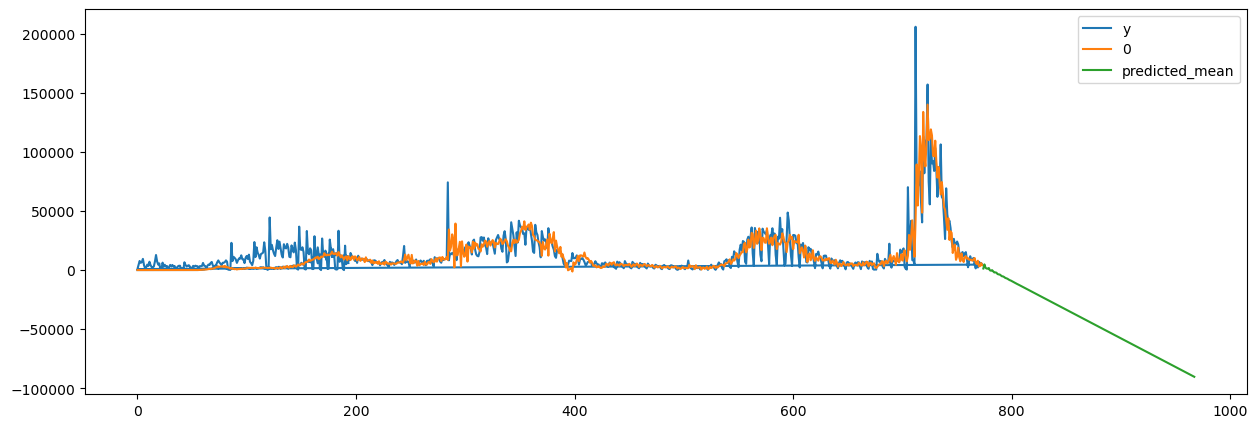

In [52]:
pd.concat([pd.concat([train, train_pred], axis = 1), pd.concat([test, test_pred], axis = 1)], axis = 0).plot(figsize = (15,5))

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  774
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -8190.853
Date:                Wed, 21 Feb 2024   AIC                          16403.706
Time:                        20:10:42   BIC                          16454.845
Sample:                             0   HQIC                         16423.384
                                - 774                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4445      0.048    -29.869      0.000      -1.539      -1.350
ar.L2         -1.1817      0.089    -13.288      0.000      -1.356      -1.007
ar.L3         -0.5292      0.094     -5.641      0.000      -0.713      -0.345
ar.L4          0.1639      0.077      2.135      0.033       0.013       0.314
ar.L5          0.1952      0.050      3.942      0.000       0.098       0.292
ma.L1         -0.1709      0.050     -3.420      0.001      -0.269      -0.073
ma.L2         -0.6712      0.040    -16.677      0.000      -0.750      -0.592
ma.L3         -0.5257      0.064     -8.197      0.000      -0.651      -0.400
ma.L4         -0.0345      0.045     -0.761      0.447      -0.123       0.054
ma.L5          0.6615      0.043     15.252      0.000       0.576       0.747
sigma2      1.236e+08   2.52e-09    4.9e+16      0.000    1.24e+08    1.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):            422617.98
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              67.98   Skew:                             6.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.58e+32. Standard errors may be unstable.
"""

In [25]:
test_pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)